In [1]:
#export
from exp.nb_04 import *

### Initial setup

In [2]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)
nb,bs=50,512
c=y_train.max().item()+1
loss_func=F.cross_entropy

In [3]:
data=DataBunch(*get_dls(train_ds,valid_ds,bs),c)

In [4]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data),loss_func,data)

In [5]:
learn = create_learner(get_model,loss_func,data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3,learn)

train: [0.6638698774514739, tensor(0.8096)]
valid: [0.30679970703125, tensor(0.9119)]
train: [0.3018461994289123, tensor(0.9124)]
valid: [0.253660009765625, tensor(0.9269)]
train: [0.24688555530666076, tensor(0.9295)]
valid: [0.212572802734375, tensor(0.9399)]


In [6]:
learn = create_learner(partial(get_model,lr=0.3),loss_func,data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3,learn)

train: [0.7664034342028431, tensor(0.7961)]
valid: [0.343393798828125, tensor(0.9069)]
train: [0.34695855366815, tensor(0.9008)]
valid: [0.2957028564453125, tensor(0.9149)]
train: [0.2988493221322286, tensor(0.9135)]
valid: [0.2629549072265625, tensor(0.9243)]


In [7]:
#export
def get_model_func(lr=0.5): return partial(get_model,lr=lr)

### Annealing

In [8]:
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses=[],[]
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): 
        self.pname, self.sched_func = pname, sched_func
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
        
    def begin_batch(self):
        if self.in_train: self.set_param()

In [9]:
def sched_lin(start,end):
    def _inner(start,end,pos): return start+pos*(end-start)
    return partial(_inner,start,end)

In [10]:
#export
def annealer(f):
    def _inner(start,end): return partial(f,start,end)
    return _inner

@annealer
def sched_lin(start,end,pos): return start + pos*(end-start)

In [16]:
f = sched_lin(2,1)
f(0.3)

1.7

In [19]:
#export
@annealer
def sched_cos(start,end,pos):return start+(1+math.cos(math.pi*(1-pos)))*(end-start)/2
@annealer
def sched_no(start,end,pos):return start
@annealer
def sched_exp(start,end,pos): return start*(end/start)**pos

In [20]:
#this money-patch is there to be able to plot tensors
torch.Tensor.ndim=property(lambda x: len(x.shape))

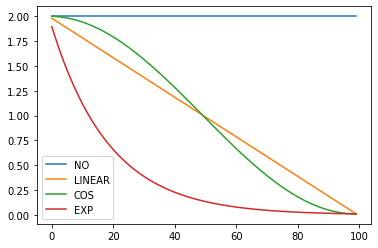

In [21]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [22]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [24]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

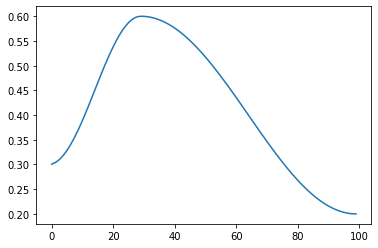

In [25]:
plt.plot(a,[sched(o) for o in p])

In [26]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [28]:
learn = create_learner(get_model_func(0.3),loss_func,data)
run = Runner(cb_funcs=cbfs)

In [29]:
run.fit(3,learn)

train: [0.7829250060405928, tensor(0.7776)]
valid: [0.325288623046875, tensor(0.9063)]
train: [0.3002692743674996, tensor(0.9114)]
valid: [0.2346394775390625, tensor(0.9326)]
train: [0.2396099051249396, tensor(0.9313)]
valid: [0.214046533203125, tensor(0.9402)]


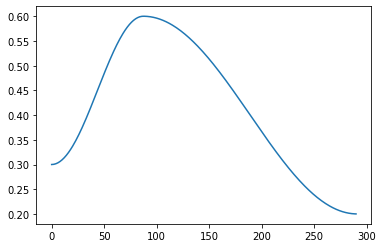

In [30]:
run.recorder.plot_lr()

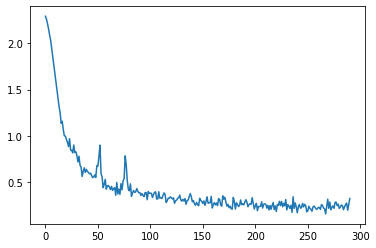

In [31]:
run.recorder.plot_loss()

### Export

In [34]:
!python3 notebook2script.py 05_Anneal.ipynb

Converted 05_Anneal.ipynb to exp/nb_05.py
